   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss
1,0.479100,0.425357
2,0.336500,0.544772
3,0.315200,0.658183


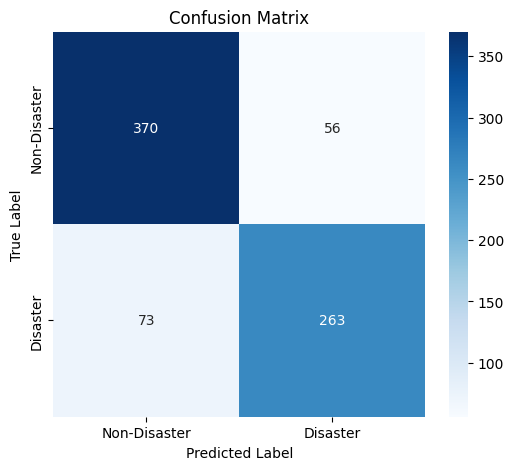

Classification Report:
               precision    recall  f1-score   support

Non-Disaster       0.84      0.87      0.85       426
    Disaster       0.82      0.78      0.80       336

    accuracy                           0.83       762
   macro avg       0.83      0.83      0.83       762
weighted avg       0.83      0.83      0.83       762

✅ Final submission saved at: /content/submission_1.csv


In [1]:
# Install required libraries
!pip install transformers torch scikit-learn pandas matplotlib seaborn

# Import necessary libraries
import pandas as pd
import torch
import os
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset, DataLoader, TensorDataset

# ✅ Ensure reproducibility
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# ✅ Disable Weights & Biases logging to avoid unnecessary API key prompt
os.environ["WANDB_DISABLED"] = "true"

# ✅ Set device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ✅ Define file paths for Google Colab
train_path = "/content/train.csv"
test_path = "/content/test.csv"
submission_path = "/content/submission_1.csv"  # ✅ Save predictions here

# ✅ Load the datasets
try:
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
except FileNotFoundError:
    print("⚠️ Error: CSV files not found. Ensure the file paths are correct.")
    exit()

# ✅ Check dataset structure
print("Train Dataset Sample:\n", train_df.head())
print("Test Dataset Sample:\n", test_df.head())

# ✅ Ensure columns exist in the dataset
required_columns = {"text", "target"}
if not required_columns.issubset(train_df.columns):
    print(f"⚠️ Error: Train dataset must contain {required_columns}. Found columns: {train_df.columns}")
    exit()

# ✅ Define BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# ✅ Split training data into train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_df["text"].tolist(), train_df["target"].tolist(), test_size=0.1, random_state=SEED
)

# ✅ Tokenization function
def tokenize_function(texts):
    return tokenizer(texts, truncation=True, padding="max_length", max_length=128)

# ✅ Tokenize train and validation datasets
train_encodings = tokenize_function(train_texts)
val_encodings = tokenize_function(val_texts)

# ✅ Create PyTorch dataset class
class DisasterTweetDataset(Dataset):
    def __init__(self, encodings, labels):
        assert len(encodings["input_ids"]) == len(labels), "Dataset length mismatch!"
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

# ✅ Create train and validation datasets (tensors stay on CPU)
train_dataset = DisasterTweetDataset(train_encodings, train_labels)
val_dataset = DisasterTweetDataset(val_encodings, val_labels)

# ✅ Load BERT model for binary classification
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.to(device)  # Move model to the correct device

# ✅ Define training arguments (Ensure reproducibility)
training_args = TrainingArguments(
    output_dir="./results",
    run_name="bert_disaster_tweets",
    evaluation_strategy="epoch",  # Evaluates after every epoch
    save_strategy="epoch",  # Saves model checkpoints per epoch
    logging_dir="./logs",
    logging_steps=50,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    seed=SEED,  # Ensures reproducibility
)

# ✅ Create Trainer with training & validation datasets
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# ✅ Train the model
trainer.train()

# ✅ Evaluate model on validation set
val_predictions = trainer.predict(val_dataset)
val_predicted_labels = torch.argmax(torch.tensor(val_predictions.predictions), axis=1).cpu().numpy()

# ✅ Generate a confusion matrix
conf_matrix = confusion_matrix(val_labels, val_predicted_labels)

# ✅ Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Disaster", "Disaster"], yticklabels=["Non-Disaster", "Disaster"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# ✅ Print classification report
print("Classification Report:\n", classification_report(val_labels, val_predicted_labels, target_names=["Non-Disaster", "Disaster"]))

# ✅ **Predict on Test Data**
# Tokenize test data
if "text" not in test_df.columns:
    print("⚠️ Error: Test dataset must contain a 'text' column.")
    exit()

test_encodings = tokenize_function(test_df["text"].tolist())

# Convert test data to tensor format (keep on CPU for DataLoader)
test_dataset = TensorDataset(
    torch.tensor(test_encodings["input_ids"]),
    torch.tensor(test_encodings["attention_mask"])
)

# Create DataLoader for test dataset
test_dataloader = DataLoader(test_dataset, batch_size=8)

# ✅ Make predictions on test set
model.eval()
test_predicted_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_mask = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        test_predicted_labels.extend(predictions.cpu().tolist())  # Move predictions back to CPU

# ✅ Save predictions in submission format
if "id" not in test_df.columns:
    print("⚠️ Error: Test dataset must contain an 'id' column.")
    exit()

submission_df = pd.DataFrame({"id": test_df["id"], "target": test_predicted_labels})
submission_df.to_csv(submission_path, index=False)

print(f"✅ Final submission saved at: {submission_path}")
